### TissueMNIST

```
Data Modality: Kidney Cortex Microscope
Task: Multi-Class (8)
Number of Samples: 236,386 (165,466 / 23,640 / 47,280)
Source Data:
Vebjorn Ljosa, Katherine L Sokolnicki, et al., “Annotated high-throughput microscopy imagesets for validation.,” Nature methods, vol. 9, no. 7, pp.637–637, 2012.
```

#### Description

```
Description: We use the BBBC051, available from the Broad Bioimage Benchmark Collection. The dataset contains 236,386 human kidney cortex cells, segmented from 3 reference tissue specimens and organized into 8 categories. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. Each gray-scale image is 32×32×7 pixels, where 7 denotes 7 slices. We take maximum values across the slices and resize them into 28×28 gray-scale images.

Url: https://zenodo.org/record/5208230/files/tissuemnist.npz?download=1

Md5: ebe78ee8b05294063de985d821c1c34b

Task: multi-class

Label: {'0': 'Collecting Duct, Connecting Tubule', '1': 'Distal Convoluted Tubule', '2': 'Glomerular endothelial cells', '3': 'Interstitial endothelial cells', '4': 'Leukocytes', '5': 'Podocytes', '6': 'Proximal Tubule Segments', '7': 'Thick Ascending Limb'}

N_channels: 1

N_samples: {'train': 165466, 'val': 23640, 'test': 47280}

License: CC BY 3.0
```

The original data was collected from 3 reference tissue specimens. But this demo we have modified this number to 1000 different specimens i.e. the cell images have been distributed randomly across the 1000 different patient ids.  This has been to done to demonstrate that through our platform we can perform multiple queries while preserving the privacy of a large group of people at scale.

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import uuid
import json
import shutil

#### Download raw dataset

In [2]:
# Download raw dataset

URL = "https://zenodo.org/record/5208230/files/tissuemnist.npz?download=1"
rawdataset_folder = "TissueMNIST/rawdata"
raw_dataset_filename = f"{rawdataset_folder}/tissuemnist.npz"
if os.path.exists(raw_dataset_filename):
    print("Raw dataset already downloaded.")
else:
    if os.path.exists(rawdataset_folder):
        print("Raw dataset directory already exists. Clearing existing one.")
        shutil.rmtree(rawdataset_folder)
    os.makedirs(rawdataset_folder)
    print("Raw data directory created.")
    os.system(f"curl -O --output-dir {rawdataset_folder} {URL}")

Raw dataset already downloaded.


In [3]:
# list raw dataset
!ls $rawdataset_folder

tissuemnist.npz


In [4]:
# Create data subset directory

data_subset_folder = "TissueMNIST/subsets"
if os.path.exists(data_subset_folder):    
    print("Data subset directory already Exists. Clearing existing one.")
    shutil.rmtree(data_subset_folder)

os.makedirs(data_subset_folder)
print("Data subset directory created.")

Data subset directory already Exists. Clearing existing one.
Data subset directory created.


In [5]:
def calc_label_frequency(labels):
    from collections import defaultdict
    labels = labels.flatten() if hasattr(labels, "flatten") else labels
    freq = defaultdict(int)
    for label in labels:
        freq[label] += 1
    return dict(freq)

#### Load Dataset

In [6]:
raw_data = np.load(raw_dataset_filename)
raw_data.files

['train_images',
 'train_labels',
 'val_images',
 'val_labels',
 'test_images',
 'test_labels']

In [7]:
train_labels = raw_data["train_labels"]
val_labels = raw_data["val_labels"]
test_labels = raw_data["test_labels"]

In [8]:
labels = np.concatenate((train_labels, val_labels, test_labels))

In [9]:
calc_label_frequency(labels)

{0: 75822, 6: 56005, 1: 11164, 3: 22009, 4: 16842, 7: 35155, 5: 11008, 2: 8381}

In [10]:
train_images = raw_data["train_images"]
val_images = raw_data["val_images"]
test_images = raw_data["test_images"]

In [11]:
images = np.concatenate((train_images, val_images, test_images))

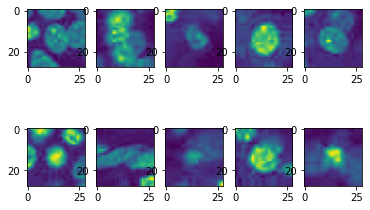

In [12]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(2, 5)
c = 0
for i in range(2):
    for j in range(5):
        axarr[i,j].imshow(images[c])
        c += 1

#### Create dataset

In [13]:
def split_into_train_test_val_sets(data, test=0.10, val=0.10):
    train = 1.0 - (test + val)
    data.reset_index(inplace=True, drop=True)
    train_msk = np.random.rand(len(data)) < train
    train = data[train_msk]

    test_val = data[~train_msk]
    _val = (val * len(data)) / len(test_val)
    val_msk = np.random.rand(len(test_val)) < _val
    val = test_val[val_msk]
    test = test_val[~val_msk]

    # reset index
    train.reset_index(inplace=True, drop=True)
    val.reset_index(inplace=True, drop=True)
    test.reset_index(inplace=True, drop=True)

    data_dict = {"train": train, "val": val, "test": test}

    return data_dict

In [14]:
image_data = [images[i] for i in range(len(images))]

In [15]:
label_data = labels.flatten()

In [16]:
df = pd.DataFrame()
df["images"] = image_data
df["labels"] = label_data

In [17]:
df.head()

,images,labels
0,"[[41, 48, 36, 13, 14, 42, 63, 65, 67, 56, 52, ...",0
1,"[[3, 6, 8, 9, 9, 10, 11, 13, 21, 25, 29, 30, 2...",0
2,"[[62, 76, 99, 112, 99, 67, 38, 24, 15, 16, 18,...",6
3,"[[9, 11, 14, 15, 13, 11, 11, 11, 14, 12, 9, 6,...",6
4,"[[45, 48, 57, 62, 52, 32, 17, 13, 15, 11, 11, ...",1


#### Create psuedo patient Ids

In [38]:
# Create 1000 unique patient ids

unique_patient_ids = [np.random.randint(low=0, high=1000000) for i in range(1000)]

In [39]:
len(set(unique_patient_ids)), len(unique_patient_ids)

(1000, 1000)

In [41]:
assert len(set(unique_patient_ids)) == 1000, "Recreate the unique patient ids"

In [23]:
patient_ids = [np.random.choice(unique_patient_ids) for _ in range(len(df))]

In [24]:
len(patient_ids) == len(df)

True

In [25]:
df["patient_ids"] = patient_ids
df = df[["patient_ids", "images", "labels"]]

#### Save the modified dataset

In [26]:
FILE_PATH = f"TissueMNIST/tissuemnist.pkl"

In [27]:
# Save to disk
df.to_pickle(FILE_PATH)

In [28]:
!ls $FILE_PATH -lh

-rw-rw-r-- 1 shubham shubham 185M May 24 12:51 TissueMNIST/tissuemnist.pkl


### Create data subsets

In [34]:
# Set total participants
TOTAL_PARTICIPANTS = 100

In [30]:
# Read the pickled dataset

df = pd.read_pickle(FILE_PATH)
df.sort_values("patient_ids", inplace=True, ignore_index=True)

In [31]:
# Create subsets

data_subsets_map = {}

for participation_number in tqdm(range(1, TOTAL_PARTICIPANTS+1)):
    # Calculate start and end index based on your participant number
    batch_size = df.shape[0] // TOTAL_PARTICIPANTS
    start_idx = (participation_number - 1) * batch_size
    end_idx = start_idx + batch_size

    # Slice the dataframe according
    subset = df[start_idx:end_idx]
    
    # Reset index of the subset
    subset.reset_index(inplace=True, drop=True)
    subset_filename = f"TissueMNIST-{uuid.uuid4().hex[:TOTAL_PARTICIPANTS]}.pkl"
    subset_path = f"{data_subset_folder}/{subset_filename}"
    subset.to_pickle(subset_path)    
    data_subsets_map[participation_number] = subset_filename
    
print("Data subsets Created Successfully !!!")

with open("dataset.json", "w") as fp:
    json.dump(data_subsets_map, fp)

100%|███████████████████████████████████| 100/100 [00:00<00:00, 133.88it/s]

Data subsets Created Successfully !!!


#### List data subset folder

In [32]:
os.listdir(data_subset_folder)

['TissueMNIST-c0e4e824d6174256a1c7cdd12b66cf40.pkl',
 'TissueMNIST-244861abc53d40cc8612442f7d54a747.pkl',
 'TissueMNIST-a92a6a179fda4375a215a18d4461b2cb.pkl',
 'TissueMNIST-fa113190c2c949228da2de8a724abc14.pkl',
 'TissueMNIST-ae974dbbb35548cd849bcad452851b67.pkl',
 'TissueMNIST-8bd1562e919a4051974bd6185b102765.pkl',
 'TissueMNIST-9d3b9ec6d32a4f35826fca34c2648452.pkl',
 'TissueMNIST-ba47265ea8234413b77cafebfc74846e.pkl',
 'TissueMNIST-cb7b1677320249d4a11e6bde7e5a0254.pkl',
 'TissueMNIST-736b36065d4e422c928a75e84908048e.pkl',
 'TissueMNIST-1e8b33b36d784152befe271c5b9bed29.pkl',
 'TissueMNIST-b5edc5f3fe7d4553956772a9a498021e.pkl',
 'TissueMNIST-706c50afcb7d47bfbb0b472c817bcd95.pkl',
 'TissueMNIST-f5aaaa9fd92c4680a65fa9068ae81fde.pkl',
 'TissueMNIST-9228ebcabd0343c092263fcc061389b1.pkl',
 'TissueMNIST-7bba4d5444784097bf836900fdab543c.pkl',
 'TissueMNIST-6716f3414ac444b7896b3b8042b3eee1.pkl',
 'TissueMNIST-637bedae1b264750a91548edc552e357.pkl',
 'TissueMNIST-064ce4c5e7fb4351b7ec375ba6ecafb0

#### Check data subset stats

In [33]:
print("Data subset stats:")
for filename in os.listdir(data_subset_folder):
    df = pd.read_pickle(f"TissueMNIST/subsets/{filename}")
    print("Unique patients:",df["patient_ids"].nunique())
    print("Label Distribution:")
    print(pd.value_counts(df["labels"]))
    print("------------------------------------------------------")

Data subset stats:
Unique patients: 11
Label Distribution:
0    739
6    587
7    360
3    220
4    163
1    114
5     96
2     84
Name: labels, dtype: int64
------------------------------------------------------
Unique patients: 11
Label Distribution:
0    708
6    582
7    353
3    202
4    183
5    131
1    113
2     91
Name: labels, dtype: int64
------------------------------------------------------
Unique patients: 11
Label Distribution:
0    705
6    569
7    336
3    247
4    176
1    116
5    110
2    104
Name: labels, dtype: int64
------------------------------------------------------
Unique patients: 11
Label Distribution:
0    757
6    550
7    337
3    214
4    196
5    122
1    107
2     80
Name: labels, dtype: int64
------------------------------------------------------
Unique patients: 11
Label Distribution:
0    793
6    561
7    338
3    222
4    164
5    103
1     99
2     83
Name: labels, dtype: int64
------------------------------------------------------
Unique pati